In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split  # Add this import statement
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:
labels_diction = {
    'Bacterial leaf blight': 0,
    'Brown spot': 1,
    'Leaf smut': 2,
}

In [5]:
data_dir = '/content/drive/MyDrive/rice_leaf_diseases'

In [6]:
X = []
y = []
for folder in os.listdir(data_dir):
    label = labels_diction[folder]
    for image in os.listdir(os.path.join(data_dir, folder)):
        image_path = os.path.join(data_dir, folder, image)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))  # VGG19 input shape is (224, 224)
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [10]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers[:-4]:  # Fine-tuning last few layers
    layer.trainable = False

In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels_diction), activation='softmax')(x)


In [13]:
model = Model(inputs=base_model.input, outputs=output)

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [23]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)


Epoch 1/20
3/3 [==============================] - 96s 35s/step - loss: 0.2374 - accuracy: 0.9271 - val_loss: 1.2753 - val_accuracy: 0.6250
Epoch 2/20
3/3 [==============================] - 93s 33s/step - loss: 0.2391 - accuracy: 0.9271 - val_loss: 1.3022 - val_accuracy: 0.7500
Epoch 3/20
3/3 [==============================] - 98s 36s/step - loss: 0.2894 - accuracy: 0.9167 - val_loss: 1.3212 - val_accuracy: 0.7083
Epoch 4/20
3/3 [==============================] - 98s 36s/step - loss: 0.2071 - accuracy: 0.9479 - val_loss: 1.2507 - val_accuracy: 0.7917
Epoch 5/20
3/3 [==============================] - 99s 36s/step - loss: 0.1892 - accuracy: 0.9375 - val_loss: 1.1139 - val_accuracy: 0.7917
Epoch 6/20
3/3 [==============================] - 98s 35s/step - loss: 0.1496 - accuracy: 0.9375 - val_loss: 1.5356 - val_accuracy: 0.7083
Epoch 7/20
3/3 [==============================] - 94s 33s/step - loss: 0.1169 - accuracy: 0.9792 - val_loss: 1.4948 - val_accuracy: 0.7500
Epoch 8/20
3/3 [===========

Training Accuracy: 0.90625
Training Loss: 0.32809218764305115



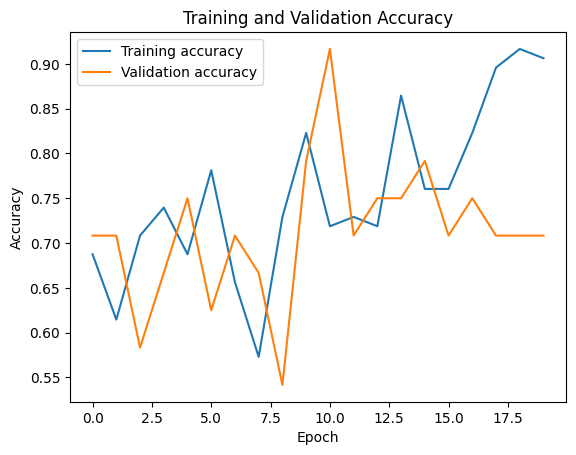

In [20]:
final_training_accuracy = history.history['accuracy'][-1]
final_training_loss = history.history['loss'][-1]
print(f"Training Accuracy: {final_training_accuracy}")
print(f"Training Loss: {final_training_loss}")
print("")

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
model.save('rice_leaf_diseases_model_VGG19_finetuned.h5')


In [22]:
image_path = '/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG'
test_image = PIL.Image.open(image_path)
resized_image = test_image.resize((224, 224))
resized_image = np.array(resized_image) / 255.0
resized_image = resized_image[np.newaxis, ...]
prediction = model.predict(resized_image)
predicted_class_index = np.argmax(prediction)

print('Predicted class index:', predicted_class_index)
predicted_label = {v: k for k, v in labels_diction.items()}.get(predicted_class_index)
print('Predicted label:', predicted_label)

1/1 [==============================] - 1s 575ms/step
Predicted class index: 0
Predicted label: Bacterial leaf blight
